### Problem statement -> <i>Regression Problem</i>
<strong>Forecast</strong> The price of Ethereum using LSTM

Documentation: 
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://iopscience.iop.org/article/10.1088/1742-6596/1982/1/012013/pdf

<strong>Important Books </strong>
- https://github.com/aaaastark/Data-Scientist-Books/blob/main/Long%20Short-Term%20Memory%20Networks%20With%20Python%20Develop%20Sequence%20Prediction%20Models%20With%20Deep%20Learning%20by%20Jason%20Brownlee%20(z-lib.org).pdf

<strong>Import the Necessary Libraries/Modules </strong>

In [1]:
import pandas as pd
import numpy as np
import ta
import time
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### API Connection and data downloading


In [2]:
df = pd.read_csv("ETH_USD_1HR.csv")
df

,close,epoch,high,low,open
0,2052.5850,1701255600,2056.895,2045.5260,2048.0650
1,2053.7550,1701259200,2060.615,2050.1450,2052.5850
2,2053.6150,1701262800,2061.845,2051.7550,2053.7550
3,2036.4850,1701266400,2058.835,2032.4915,2053.3425
4,2031.3500,1701270000,2040.395,2020.2950,2036.2850
...,...,...,...,...,...
4994,3323.4350,1719234000,3328.195,3291.3950,3317.9950
4995,3306.7450,1719237600,3331.734,3292.0050,3323.4350
4996,3278.6850,1719241200,3312.755,3260.6965,3307.2150
4997,3259.6875,1719244800,3291.445,3241.3980,3278.7950


In [3]:
data_history = df.copy()
data_history

,close,epoch,high,low,open
0,2052.5850,1701255600,2056.895,2045.5260,2048.0650
1,2053.7550,1701259200,2060.615,2050.1450,2052.5850
2,2053.6150,1701262800,2061.845,2051.7550,2053.7550
3,2036.4850,1701266400,2058.835,2032.4915,2053.3425
4,2031.3500,1701270000,2040.395,2020.2950,2036.2850
...,...,...,...,...,...
4994,3323.4350,1719234000,3328.195,3291.3950,3317.9950
4995,3306.7450,1719237600,3331.734,3292.0050,3323.4350
4996,3278.6850,1719241200,3312.755,3260.6965,3307.2150
4997,3259.6875,1719244800,3291.445,3241.3980,3278.7950


## Feature Engineering
Here we introduce all the features we need (indicators, std, price action etc..)
* roc
* willims r indicator
* ATr
* cci
* stddev
* Aroon
* ema_9
* ema_20
* ema_50,
* ADX,
* RSI
* Candle size

### Trend Indicators
* EMA_9, EMA_20, EMA_50, Aroon indicator, adx indicator, cci indicator,

In [4]:
ema_9 = ta.trend.EMAIndicator(close=df['close'], window=9)
ema_20 = ta.trend.EMAIndicator(close=df['close'], window=20)
df = df.assign(ema_9 = ema_9.ema_indicator())
df = df.assign(ema_20 = ema_20.ema_indicator())
adx = ta.trend.ADXIndicator(high=df['high'],low=df['low'], close=df['close'], window=14).adx()
df = df.assign(adx=adx)
cci = ta.trend.CCIIndicator(high=df['high'], low=df['low'], close=df['close'], window=14).cci()
df = df.assign(cci=cci)

### Momentum Indicators
* Rsi, candle size, ROC,Williams %r

In [5]:
true_candle_size = df['close'] - df['open']
df = df.assign(true_candle_size = true_candle_size)
rsi_value = ta.momentum.RSIIndicator(close=df['close'], window=14)
df = df.assign(rsi = rsi_value.rsi())
williams = ta.momentum.WilliamsRIndicator(high=df['high'], low=df['low'], close=df['close'], lbp=14).williams_r()
df = df.assign(williams = williams)

## Volatility Indicators
* ATR indicator, BOllinger Bands Parameters, 

In [6]:
df

,close,epoch,high,low,open,ema_9,ema_20,adx,cci,true_candle_size,rsi,williams
0,2052.5850,1701255600,2056.895,2045.5260,2048.0650,NaN,NaN,0.000000,NaN,4.5200,NaN,NaN
1,2053.7550,1701259200,2060.615,2050.1450,2052.5850,NaN,NaN,0.000000,NaN,1.1700,NaN,NaN
2,2053.6150,1701262800,2061.845,2051.7550,2053.7550,NaN,NaN,0.000000,NaN,-0.1400,NaN,NaN
3,2036.4850,1701266400,2058.835,2032.4915,2053.3425,NaN,NaN,0.000000,NaN,-16.8575,NaN,NaN
4,2031.3500,1701270000,2040.395,2020.2950,2036.2850,NaN,NaN,0.000000,NaN,-4.9350,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,3323.4350,1719234000,3328.195,3291.3950,3317.9950,3343.184033,3380.968287,64.330997,-93.495241,5.4400,25.326321,-51.165367
4995,3306.7450,1719237600,3331.734,3292.0050,3323.4350,3335.896226,3373.899402,65.129209,-84.035050,-16.6900,22.814543,-57.479941
4996,3278.6850,1719241200,3312.755,3260.6965,3307.2150,3324.453981,3364.831364,66.118811,-110.290653,-28.5300,19.341466,-70.801880
4997,3259.6875,1719244800,3291.445,3241.3980,3278.7950,3311.500685,3354.817663,67.167026,-125.431904,-19.1075,17.409168,-79.043193


In [7]:
atr = ta.volatility.AverageTrueRange(high=df['high'],
                                     low=df['low'], 
                                     close=df['close'],
                                     window=14).average_true_range()
df = df.assign(atr=atr)
bol_width = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2).bollinger_wband()
df = df.assign(bol_width=bol_width)
bol_above = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2).bollinger_hband_indicator()
df = df.assign(bol_above=bol_above)
bol_below = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2).bollinger_lband_indicator()
df = df.assign(bol_below=bol_below)

<strong>Del `epoch` </strong>

In [8]:
epoch = 'epoch'
col = df.columns
if epoch in col:
    del df['epoch']

In [9]:
immediate_trend = ((df['close'] >= df['ema_9']) & (df['close'] >= df['ema_20'])).astype(int)
df = df.assign(immediate_trend = immediate_trend)

In [10]:
df[-30:]

,close,high,low,open,ema_9,ema_20,adx,cci,true_candle_size,rsi,williams,atr,bol_width,bol_above,bol_below,immediate_trend
4969,3498.8350,3502.545,3494.6285,3496.8850,3501.352872,3502.306323,10.246313,-70.535665,1.9500,47.462728,-63.533932,11.335208,0.863424,0.0,0.0,0
4970,3496.4050,3503.085,3492.0050,3498.8350,3500.363298,3501.744293,10.565343,-89.688843,-2.4300,45.934521,-70.974112,11.316979,0.863647,0.0,0.0,0
4971,3483.4850,3497.995,3479.3890,3496.4050,3496.987638,3500.005312,11.961849,-159.417426,-12.9200,38.784207,-89.810058,11.837624,0.952745,0.0,1.0,0
4972,3472.9950,3488.406,3470.3450,3483.4020,3492.189110,3497.432902,13.869439,-185.934995,-10.4070,34.137782,-94.618251,12.282151,1.163512,0.0,1.0,0
4973,3461.5150,3481.195,3460.0050,3472.9950,3486.054288,3494.012149,16.214397,-194.355225,-11.4800,29.914102,-97.465614,12.918425,1.519402,0.0,1.0,0
4974,3471.6750,3478.865,3460.1950,3461.5150,3483.178431,3491.884802,18.391859,-142.423964,10.1600,37.306948,-80.413055,13.329252,1.662071,0.0,0.0,0
4975,3476.3250,3477.325,3470.6950,3471.6750,3481.807745,3490.402916,20.413788,-96.464522,4.6500,40.405312,-71.252422,12.850734,1.743019,0.0,0.0,0
4976,3478.8750,3480.655,3474.0050,3476.3250,3481.221196,3489.305019,21.767023,-66.679430,2.5500,42.095358,-64.367317,12.407825,1.797761,0.0,0.0,0
4977,3434.1350,3479.105,3407.6250,3478.8750,3471.803957,3484.050731,25.266694,-201.015262,-44.7400,27.408771,-74.833155,16.627266,2.341479,0.0,1.0,0
4978,3433.7750,3439.031,3405.7210,3434.1350,3464.198165,3479.262567,28.549269,-203.266567,-0.3600,27.326157,-73.536334,17.818890,2.723690,0.0,1.0,0


In [11]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998
close,2052.585,2053.755,2053.615,2036.4850,2031.350,2025.925,2032.445,2037.283,2038.55000,2025.69500,...,3383.205000,3306.995000,3317.628500,3319.382500,3317.745000,3323.435000,3306.745000,3278.685000,3259.687500,3292.505000
high,2056.895,2060.615,2061.845,2058.8350,2040.395,2033.825,2037.705,2037.845,2042.09500,2039.88150,...,3392.995000,3388.215000,3323.365000,3330.395000,3335.425000,3328.195000,3331.734000,3312.755000,3291.445000,3302.403000
low,2045.526,2050.145,2051.755,2032.4915,2020.295,2019.145,2020.035,2028.275,2032.83200,2019.39500,...,3353.325000,3217.185000,3302.805000,3304.255000,3310.045000,3291.395000,3292.005000,3260.696500,3241.398000,3245.082500
open,2048.065,2052.585,2053.755,2053.3425,2036.285,2031.455,2025.925,2032.625,2037.27500,2038.47500,...,3367.675000,3383.205000,3306.995000,3316.828500,3319.395000,3317.995000,3323.435000,3307.215000,3278.795000,3258.785000
ema_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2039.33015,2036.60312,...,3393.990125,3376.591100,3364.798580,3355.715364,3348.121291,3343.184033,3335.896226,3324.453981,3311.500685,3307.701548
ema_20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3422.066828,3411.107606,3402.204834,3394.316993,3387.024422,3380.968287,3373.899402,3364.831364,3354.817663,3348.883123
adx,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.000,0.00000,0.00000,...,56.617984,58.770884,60.770006,62.205838,63.232754,64.330997,65.129209,66.118811,67.167026,67.494243
cci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-97.972409,-233.733449,-160.109221,-126.337618,-102.015135,-93.495241,-84.035050,-110.290653,-125.431904,-91.069597
true_candle_size,4.520,1.170,-0.140,-16.8575,-4.935,-5.530,6.520,4.658,1.27500,-12.78000,...,15.530000,-76.210000,10.633500,2.554000,-1.650000,5.440000,-16.690000,-28.530000,-19.107500,33.720000
rsi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.682438,17.552924,22.095198,22.850239,22.629732,25.326321,22.814543,19.341466,17.409168,30.353453


In [12]:
dif = df.copy()
dif

,close,high,low,open,ema_9,ema_20,adx,cci,true_candle_size,rsi,williams,atr,bol_width,bol_above,bol_below,immediate_trend
0,2052.5850,2056.895,2045.5260,2048.0650,NaN,NaN,0.000000,NaN,4.5200,NaN,NaN,0.000000,NaN,0.0,0.0,0
1,2053.7550,2060.615,2050.1450,2052.5850,NaN,NaN,0.000000,NaN,1.1700,NaN,NaN,0.000000,NaN,0.0,0.0,0
2,2053.6150,2061.845,2051.7550,2053.7550,NaN,NaN,0.000000,NaN,-0.1400,NaN,NaN,0.000000,NaN,0.0,0.0,0
3,2036.4850,2058.835,2032.4915,2053.3425,NaN,NaN,0.000000,NaN,-16.8575,NaN,NaN,0.000000,NaN,0.0,0.0,0
4,2031.3500,2040.395,2020.2950,2036.2850,NaN,NaN,0.000000,NaN,-4.9350,NaN,NaN,0.000000,NaN,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,3323.4350,3328.195,3291.3950,3317.9950,3343.184033,3380.968287,64.330997,-93.495241,5.4400,25.326321,-51.165367,32.930919,6.016045,0.0,0.0,0
4995,3306.7450,3331.734,3292.0050,3323.4350,3335.896226,3373.899402,65.129209,-84.035050,-16.6900,22.814543,-57.479941,33.416496,5.919135,0.0,0.0,0
4996,3278.6850,3312.755,3260.6965,3307.2150,3324.453981,3364.831364,66.118811,-110.290653,-28.5300,19.341466,-70.801880,34.748068,5.885943,0.0,0.0,0
4997,3259.6875,3291.445,3241.3980,3278.7950,3311.500685,3354.817663,67.167026,-125.431904,-19.1075,17.409168,-79.043193,35.840849,6.312871,0.0,0.0,0


### Clean the Data

In [13]:
df.isnull().sum()

close                0
high                 0
low                  0
open                 0
ema_9                8
ema_20              19
adx                  0
cci                 13
true_candle_size     0
rsi                 13
williams            13
atr                  0
bol_width           19
bol_above            0
bol_below            0
immediate_trend      0
dtype: int64

In [14]:
df.dropna(inplace=True)
df

,close,high,low,open,ema_9,ema_20,adx,cci,true_candle_size,rsi,williams,atr,bol_width,bol_above,bol_below,immediate_trend
19,2034.7550,2038.765,2031.1650,2033.655,2033.764577,2036.185346,0.000000,56.417579,1.1000,45.877046,-36.371168,11.413426,1.736408,0.0,0.0,0
20,2035.5150,2038.735,2032.5250,2034.755,2034.114662,2036.121504,0.000000,59.415942,0.7600,46.868032,-33.222867,11.041753,1.550776,0.0,0.0,0
21,2025.6350,2036.645,2020.4350,2035.515,2032.418729,2035.122789,0.000000,-68.904087,-9.8800,37.305251,-74.150787,11.410913,1.322335,0.0,0.0,0
22,2028.7850,2032.535,2022.0050,2025.635,2031.691983,2034.519190,0.000000,-57.221548,3.1500,41.409847,-61.101906,11.347991,0.946180,0.0,0.0,0
23,2029.8050,2033.675,2027.5750,2028.785,2031.314587,2034.070220,0.000000,-13.812805,1.0200,42.717627,-59.437229,10.973135,0.923887,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,3323.4350,3328.195,3291.3950,3317.995,3343.184033,3380.968287,64.330997,-93.495241,5.4400,25.326321,-51.165367,32.930919,6.016045,0.0,0.0,0
4995,3306.7450,3331.734,3292.0050,3323.435,3335.896226,3373.899402,65.129209,-84.035050,-16.6900,22.814543,-57.479941,33.416496,5.919135,0.0,0.0,0
4996,3278.6850,3312.755,3260.6965,3307.215,3324.453981,3364.831364,66.118811,-110.290653,-28.5300,19.341466,-70.801880,34.748068,5.885943,0.0,0.0,0
4997,3259.6875,3291.445,3241.3980,3278.795,3311.500685,3354.817663,67.167026,-125.431904,-19.1075,17.409168,-79.043193,35.840849,6.312871,0.0,0.0,0


In [15]:
df.isnull().sum()

close               0
high                0
low                 0
open                0
ema_9               0
ema_20              0
adx                 0
cci                 0
true_candle_size    0
rsi                 0
williams            0
atr                 0
bol_width           0
bol_above           0
bol_below           0
immediate_trend     0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4980 entries, 19 to 4998
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   close             4980 non-null   float64
 1   high              4980 non-null   float64
 2   low               4980 non-null   float64
 3   open              4980 non-null   float64
 4   ema_9             4980 non-null   float64
 5   ema_20            4980 non-null   float64
 6   adx               4980 non-null   float64
 7   cci               4980 non-null   float64
 8   true_candle_size  4980 non-null   float64
 9   rsi               4980 non-null   float64
 10  williams          4980 non-null   float64
 11  atr               4980 non-null   float64
 12  bol_width         4980 non-null   float64
 13  bol_above         4980 non-null   float64
 14  bol_below         4980 non-null   float64
 15  immediate_trend   4980 non-null   int32  
dtypes: float64(15), int32(1)
memory usage: 64

## Calculate the target value


In [17]:
# from sklearn.preprocessing import MinMaxScaler

The data for sequence prediction problem needs to be scaled when training a neural network, such as a Long Short-Term Memory recurrent neural network.

When a network is fit on unscaled data that has a range of values (e.g. quantities in the 10s to 100s) it is possible for large inputs to slow down the learning and convergence of the network and in some cases prevent the network from effectively learning your problem.

MinMaxscaler Scales each feature to a given range, usually [0, 1] or [-1, 1]. It transforms features by scaling them to the range of the minimum and maximum value of each feature.

 Formula:
 <br>
 $X′=\frac{X−Xmin}{Xmax−Xmin}\$
 <br>
 
Where X is the original feature value, $Xmin$ is the minimum value of the feature, and $Xmax$ is the maximum value of the feature.

<strong>Usage</strong>: Ideal when you want to preserve the relationships between values and for algorithms that assume data is within a specific range or sensitive to the scale of data (e.g., neural networks).

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [19]:
scaled_data.shape

(4980, 16)

In [20]:
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df

,close,high,low,open,ema_9,ema_20,adx,cci,true_candle_size,rsi,williams,atr,bol_width,bol_above,bol_below,immediate_trend
0,0.004455,0.003016,0.005243,0.003918,0.001210,0.001059,0.000000,0.557368,0.452146,0.414106,0.636288,0.036761,0.038749,0.0,0.0,0.0
1,0.004826,0.003001,0.005907,0.004455,0.001383,0.001027,0.000000,0.560765,0.451506,0.426501,0.667771,0.032451,0.032781,0.0,0.0,0.0
2,0.000000,0.001989,0.000000,0.004826,0.000545,0.000527,0.000000,0.415376,0.431483,0.306900,0.258492,0.036731,0.025435,0.0,0.0,0.0
3,0.001539,0.000000,0.000767,0.000000,0.000186,0.000225,0.000000,0.428612,0.456004,0.358236,0.388981,0.036002,0.013340,0.0,0.0,0.0
4,0.002037,0.000552,0.003489,0.001539,0.000000,0.000000,0.000000,0.477795,0.451996,0.374592,0.405628,0.031656,0.012623,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,0.633958,0.627162,0.621002,0.631300,0.648010,0.674276,0.940647,0.387514,0.460314,0.157080,0.488346,0.286232,0.176358,0.0,0.0,0.0
4976,0.625805,0.628875,0.621300,0.633958,0.644410,0.670737,0.952319,0.398232,0.418667,0.125666,0.425201,0.291862,0.173242,0.0,0.0,0.0
4977,0.612098,0.619688,0.606002,0.626034,0.638758,0.666197,0.966789,0.368484,0.396385,0.082228,0.291981,0.307300,0.172175,0.0,0.0,0.0
4978,0.602818,0.609373,0.596573,0.612152,0.632359,0.661184,0.982116,0.351329,0.414118,0.058061,0.209568,0.319969,0.185903,0.0,0.0,0.0


 Create a sequence of 10 rows of data with all features to predict the 11<sup>th</sup> close value

In [21]:
sequence_length = 10
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # [row, col] Here df.close is column 0 but row changes dynamically
    return np.array(sequences), np.array(targets)


In [22]:
sequences, targets = create_sequences(scaled_df.values, sequence_length)

In [23]:
scaled_df.close[:14]

0     0.004455
1     0.004826
2     0.000000
3     0.001539
4     0.002037
5     0.009545
6     0.009577
7     0.004567
8     0.001959
9     0.003688
10    0.004470
11    0.006507
12    0.006419
13    0.007625
Name: close, dtype: float64

In [24]:
targets[:3]

array([0.00446965, 0.00650664, 0.00641871])

In [25]:
sequences[1]

array([[4.82624540e-03, 3.00109879e-03, 5.90727628e-03, 4.45499575e-03,
        1.38312183e-03, 1.02690100e-03, 0.00000000e+00, 5.60764943e-01,
        4.51506272e-01, 4.26500524e-01, 6.67771334e-01, 3.24514042e-02,
        3.27805676e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.98943807e-03, 0.00000000e+00, 4.82624540e-03,
        5.45401010e-04, 5.26930731e-04, 0.00000000e+00, 4.15375920e-01,
        4.31482862e-01, 3.06899766e-01, 2.58492129e-01, 3.67314113e-02,
        2.54352044e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53873208e-03, 0.00000000e+00, 7.67115283e-04, 0.00000000e+00,
        1.86418443e-04, 2.24760797e-04, 0.00000000e+00, 4.28612457e-01,
        4.56004012e-01, 3.58235543e-01, 3.88980944e-01, 3.60018959e-02,
        1.33401912e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.03698819e-03, 5.51814939e-04, 3.48866441e-03, 1.53873208e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.777

## Splitting data into train and testing
<i><strong>Splitting the data manually without `train_test_split` function </strong></i>  <br>
since our data is in a time series domain, we cannot shuffle the data since the predicted target depends on the data before

In [26]:
len(sequences), len(targets)

(4970, 4970)

In [27]:
np.isnan(sequences).sum(), np.isnan(targets).sum()

(0, 0)

In [28]:
# Split data into training and testing sets
train_size = int(len(sequences) * 0.75)
x_train, x_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

array([0.52521567, 0.53258717, 0.52680325, ..., 0.61209785, 0.60281783,
       0.61884874])

In [29]:
# Build the LSTM model
model = Sequential()

In [30]:
x_train.shape, sequence_length

((3727, 10, 16), 10)

In [31]:
# input_shape = (10,2)

In [32]:
# Add LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, x_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization 
#Dropout is a regularization technique used to prevent overfitting in neural networks.
#  It randomly drops a certain percentage of units during training,
# Forcing the network to learn more robust features that are not dependent on specific units.

# Add another LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Add first Dense layer with ReLU activation
model.add(Dense(40, activation='relu'))

# Add second Dense layer with ReLU activation
model.add(Dense(20, activation='relu'))

# Add Dense layer
model.add(Dense(1))

In [33]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            13400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 40)                2040      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [35]:
# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
117/117 [==============================] - 13s 30ms/step - loss: 0.0117 - mean_absolute_error: 0.0643 - val_loss: 9.3304e-04 - val_mean_absolute_error: 0.0211
Epoch 2/50
117/117 [==============================] - 2s 19ms/step - loss: 0.0023 - mean_absolute_error: 0.0337 - val_loss: 0.0024 - val_mean_absolute_error: 0.0433
Epoch 3/50
117/117 [==============================] - 2s 18ms/step - loss: 0.0018 - mean_absolute_error: 0.0300 - val_loss: 0.0025 - val_mean_absolute_error: 0.0441
Epoch 4/50
117/117 [==============================] - 2s 18ms/step - loss: 0.0015 - mean_absolute_error: 0.0278 - val_loss: 0.0055 - val_mean_absolute_error: 0.0683
Epoch 5/50
117/117 [==============================] - 2s 18ms/step - loss: 0.0012 - mean_absolute_error: 0.0248 - val_loss: 6.6814e-04 - val_mean_absolute_error: 0.0181
Epoch 6/50
117/117 [==============================] - 2s 19ms/step - loss: 0.0011 - mean_absolute_error: 0.0241 - val_loss: 0.0042 - val_mean_absolute_error: 0.0589
E

117/117 [==============================] - 2s 20ms/step - loss: 3.2753e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0041 - val_mean_absolute_error: 0.0562
Epoch 50/50
117/117 [==============================] - 3s 22ms/step - loss: 3.2220e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0043 - val_mean_absolute_error: 0.0581


In [36]:
# Evaluate the model
test_loss, test_mae = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print("MAE: ", test_mae)

39/39 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_absolute_error: 0.0581
Test Loss: 0.00431111641228199
MAE:  0.05809726193547249


In [37]:
# Predict next prices
predictions = model.predict(x_test)
predictions

39/39 [==============================] - 1s 7ms/step


array([[0.5039472 ],
       [0.5040179 ],
       [0.50554115],
       ...,
       [0.5791197 ],
       [0.5698876 ],
       [0.56122094]], dtype=float32)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

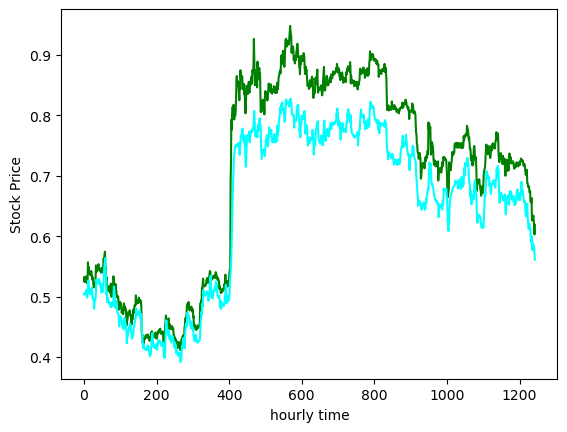

In [38]:
num = 0
plt.plot(y_test[num:], color='green')
plt.xlabel("hourly time")
plt.ylabel("Stock Price")

plt.plot(predictions[num:], color='aqua')
plt.show()

### Inversing to the original Dataframe
`Inverse_transform(...)` <br>
: This function of the scaler object reverses the scaling transformation applied earlier.
Argument to inverse_transform:

- np.hstack((predictions, x_test[:, -1, 1:])): This part constructs the data for inverse transformation.
- np.hstack: This function performs horizontal stacking (concatenation) of arrays.
- predictions: These are the predicted prices you want to transform back.
- x_test[:, -1, 1:]: This retrieves a specific portion of the test data (x_test). Here:
- [:, -1, :]: Selects the last element (likely the closing price) from each sequence in the test data.
- [:, -1, 1:]: Excludes the first feature from the selected closing prices, since there are more than one feature that have used besides the closing price for prediction, and we only need to transform the predicted prices back.

In [39]:
predicted_prices = scaler.inverse_transform(np.hstack((predictions, x_test[:, -1, 1:])))

In [40]:
predicted_prices[:,0]

array([3057.28546771, 3057.43018231, 3060.54850122, ..., 3211.17406645,
       3192.27465742, 3174.53284315])

In [41]:
predicted_close_prices = predicted_prices[:, 0]
predicted_close_prices

array([3057.28546771, 3057.43018231, 3060.54850122, ..., 3211.17406645,
       3192.27465742, 3174.53284315])

In [42]:
# Inverse transform y_test
# Reshape y_test to match the expected input format for inverse_transform
y_test_reshaped = y_test.reshape(-1, 1)

# Since we're only interested in the 'Close' column, we need to
# perform inverse transformation using only the 'Close' column of the original data.
# Create a placeholder array with shape (n_samples, n_features), where n_features includes the other columns.
# Fill other columns with zeros because we don't use them, and only the 'Close' column will be inverse transformed.
n_features = df.shape[1]  # Number of features
placeholder_array = np.zeros((y_test_reshaped.shape[0], n_features))
placeholder_array[:, 0] = y_test_reshaped[:, 0]

# Inverse transform the placeholder array
original_y_test_array = scaler.inverse_transform(placeholder_array)

# Extract the inverse-transformed 'Close' prices
original_y_test = original_y_test_array[:, 0]

In [43]:
original_y_test

array([3100.825 , 3115.9155, 3104.075 , ..., 3278.685 , 3259.6875,
       3292.505 ])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

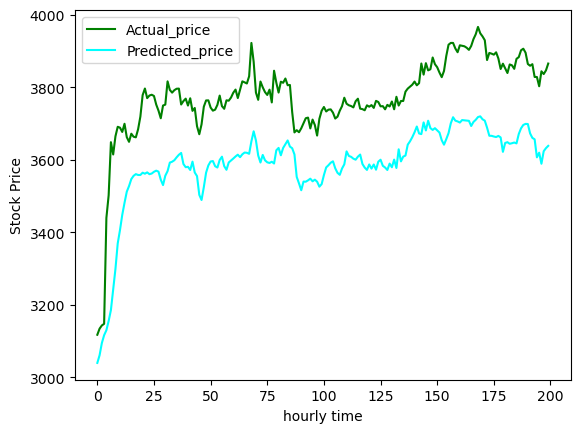

In [44]:
number = 400
plt.plot(original_y_test[number:600], color='green')
plt.xlabel("hourly time")
plt.ylabel("Stock Price")

plt.plot(predicted_close_prices[number:600], color='aqua')
plt.legend(['Actual_price','Predicted_price'])
plt.show()

## Projecting future price